<a href="https://colab.research.google.com/github/LSNMCLNTL/Skin-Cancer-Classification/blob/main/SVM_REVISION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install shap

In [ ]:
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage import color
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
from tqdm import tqdm
import pandas as pd
import shap
import ast


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Paths
image_dir = '/content/drive/My Drive/SkinLesion_dataset' #original dataset
aug_dir = '/content/drive/My Drive/SkinLesion_dataset_aug'  #augmented dataset
preprocessed_dir = '/content/drive/My Drive/SkinLesion_Preprocessed_aug' #preprocessed dataset using the aug_dir

class_dirs = ['BCC', 'SCC', 'MEL']
target_count = 500


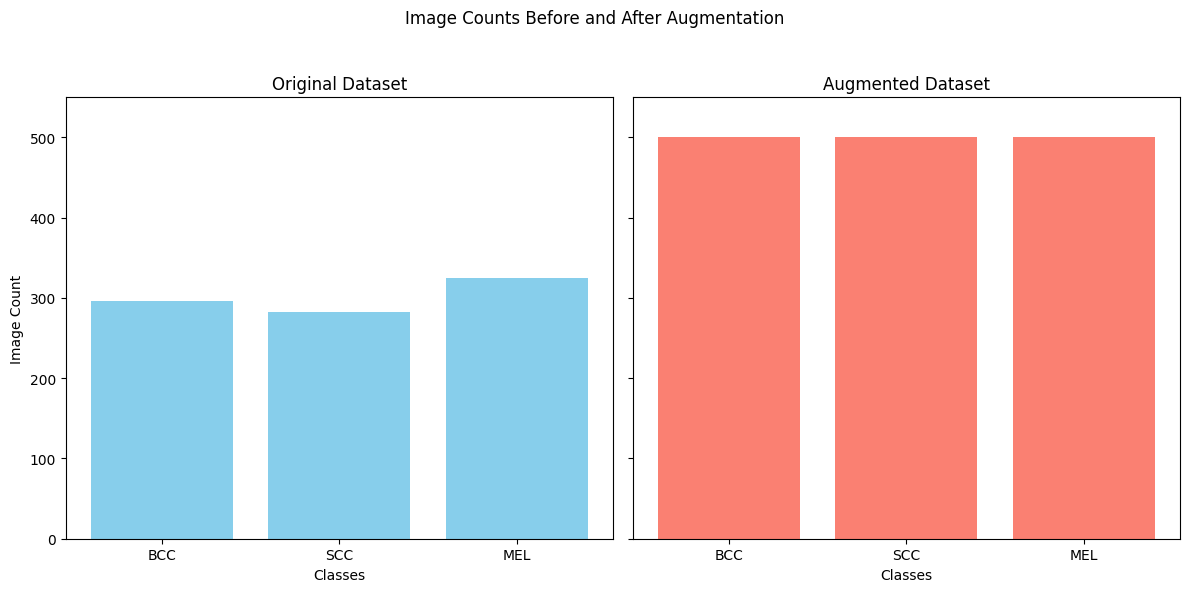

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each class in both original and augmented datasets
class_labels = ['BCC', 'SCC', 'MEL']
initial_counts = [296, 282, 325]  # Example counts from the original dataset
augmented_counts = [500, 500, 500]  # Counts after augmentation

# Creating subplots: one for each dataset (Original and Augmented)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plotting the original dataset counts
ax1.bar(class_labels, initial_counts, color='skyblue')
ax1.set_title("Original Dataset")
ax1.set_xlabel("Classes")
ax1.set_ylabel("Image Count")
ax1.set_ylim(0, 550)

# Plotting the augmented dataset counts
ax2.bar(class_labels, augmented_counts, color='salmon')
ax2.set_title("Augmented Dataset")
ax2.set_xlabel("Classes")

plt.suptitle("Image Counts Before and After Augmentation")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


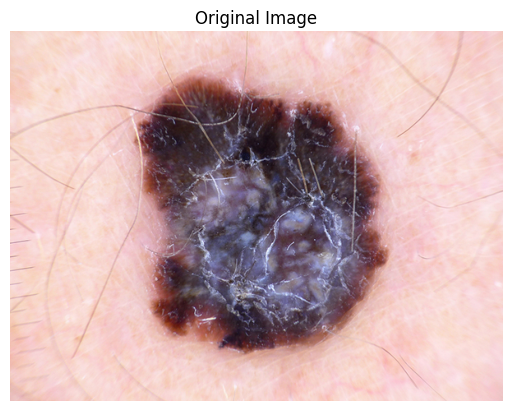

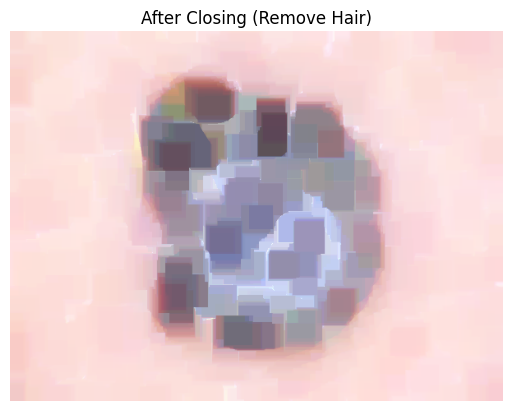

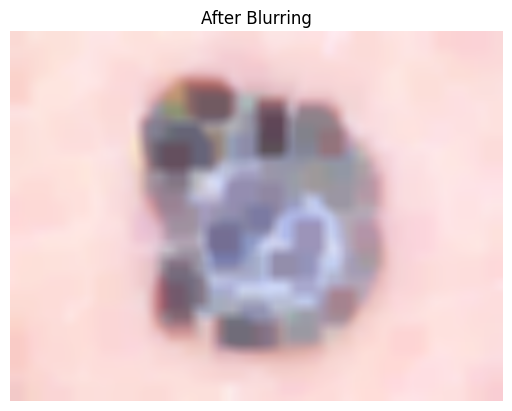

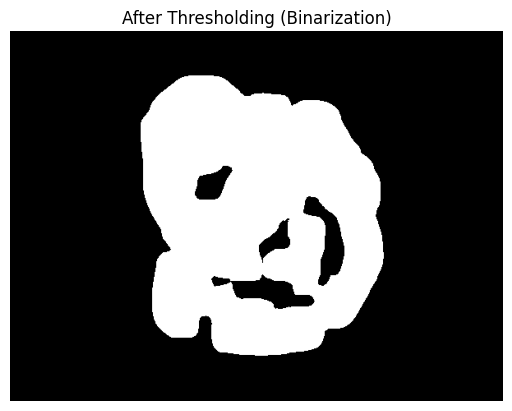

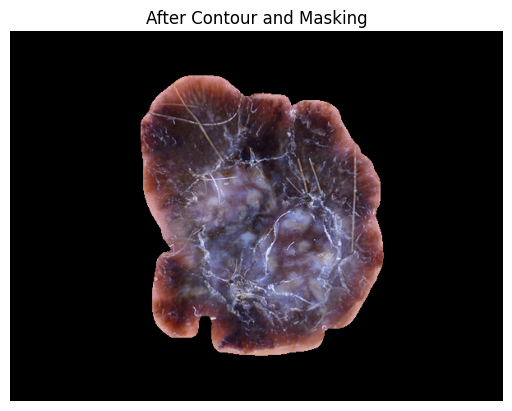

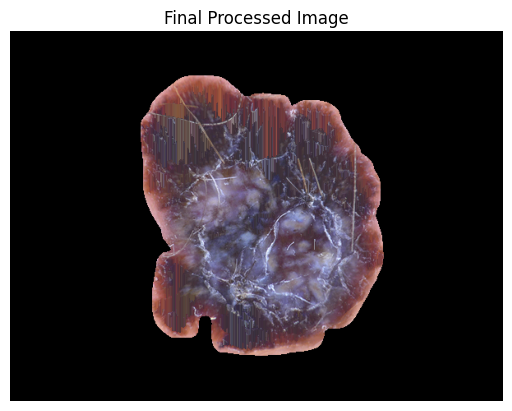

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_image(image, title="Image"):
    """Utility function to display an image"""
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_and_display_image(image_path):
    # Read and display the original image first
    img = cv2.imread(image_path)
    if img is None:
        print(f"Unable to read image at {image_path}")
        return

    show_image(img, title="Original Image")

    kernel = np.ones((15, 15), np.uint8)

    # Step 1: Perform closing to remove hair and blur the image
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    show_image(closing, title="After Closing (Remove Hair)")

    blur = cv2.blur(closing, (15, 15))
    show_image(blur, title="After Blurring")

    # Step 2: Binarize the image
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    show_image(thresh, title="After Thresholding (Binarization)")

    # Step 3: Search for contours and select the biggest one
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)

    # Step 4: Create a new mask for the result image
    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)

    # Step 5: Draw the contour on the new mask and perform the bitwise operation
    cv2.drawContours(mask, [cnt], -1, 255, -1)
    res = cv2.bitwise_and(img, img, mask=mask)
    show_image(res, title="After Contour and Masking")

    # Step 6: Convert result to PIL image and process pixel-by-pixel
    res_pil = Image.fromarray(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    pix = res_pil.load()
    x, y = res_pil.size

    # Initialize values for thresholding
    b, g, r = 0, 0, 0  # Initial values

    # Determine the thresholds based on the mean color
    mean = cv2.mean(res, mask=mask)
    if mean[2] > 182:
        bp = mean[0] / 100 * 35
        gp = mean[1] / 100 * 35
        rp = mean[2] / 100 * 35
    elif 182 > mean[2] > 160:
        bp = mean[0] / 100 * 30
        gp = mean[1] / 100 * 30
        rp = mean[2] / 100 * 30
    elif 160 > mean[2] > 150:
        bp = mean[0] / 100 * 50
        gp = mean[1] / 100 * 50
        rp = mean[2] / 100 * 50
    elif 150 > mean[2] > 120:
        bp = mean[0] / 100 * 60
        gp = mean[1] / 100 * 60
        rp = mean[2] / 100 * 60
    else:
        bp = mean[0] / 100 * 53
        gp = mean[1] / 100 * 53
        rp = mean[2] / 100 * 53

    # Step 7: Iterate through the image and replace pixels based on criteria
    for i in range(x):
        for j in range(y):
            if (0 <= pix[i, j][0] < bp or
                0 <= pix[i, j][1] < gp or
                0 <= pix[i, j][2] < rp):
                try:
                    pix[i, j] = (int(b), int(g), int(r))
                except:
                    pix[i, j] = (int(mean[0]), int(mean[1]), int(mean[2]))
            else:
                b, g, r = pix[i, j]

    res = np.array(res_pil)
    res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)

    # Step 8: Perform final bitwise operation with mask
    final = cv2.bitwise_and(res, res, mask=mask)
    show_image(final, title="Final Processed Image")

# Example usage:
image_path = '/content/drive/My Drive/SkinLesion_dataset/MEL/MEL_309.jpg'
process_and_display_image(image_path)


In [ ]:
# Ensure preprocessed directories exist
for class_dir in class_dirs:
    os.makedirs(os.path.join(aug_dir, class_dir), exist_ok=True)

for class_dir in class_dirs:
    os.makedirs(os.path.join(preprocessed_dir, class_dir), exist_ok=True)

In [ ]:
# Data augmentation generator
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Ensure augmentation directories exist
for class_dir in class_dirs:
    class_aug_dir = os.path.join(aug_dir, class_dir)
    os.makedirs(class_aug_dir, exist_ok=True)

    # Load existing images
    original_class_dir = os.path.join(image_dir, class_dir)
    images = [os.path.join(original_class_dir, img) for img in os.listdir(original_class_dir)]
    num_images = len(images)

    # Initialize a counter for augmented images
    aug_counter = num_images + 1

    # Copy original images to the augmented directory if necessary
    for img_path in images:
        shutil.copy(img_path, os.path.join(class_aug_dir, os.path.basename(img_path)))

    # If more images are needed, augment until reaching target count
    while num_images < target_count:
        for img_path in tqdm(images, desc=f'Augmenting {class_dir}', unit='image'):
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.expand_dims(img, 0)  # Reshape for generator

            # Generate a batch of augmented images
            aug_iter = datagen.flow(img, batch_size=1)
            aug_img = next(aug_iter)[0].astype(np.uint8)

            # Save augmented image with formatted name
            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            aug_img_path = os.path.join(class_aug_dir, f'{class_dir}_{aug_counter}.png')
            cv2.imwrite(aug_img_path, aug_img_bgr)

            num_images += 1
            aug_counter += 1  # Increment the counter for the next filename

            if num_images >= target_count:
                break


Augmenting MEL:  54%|█████▎    | 174/325 [00:49<00:42,  3.52image/s]


In [ ]:
# Function to process, extract features, and save images
def process_and_save_image(image_path, preprocessed_dir):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Unable to read image at {image_path}")
        return

    kernel = np.ones((15, 15), np.uint8)

    # Perform closing to remove hair and blur the image
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    blur = cv2.blur(closing, (15, 15))

    # Binarize the image
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Search for contours and select the biggest one
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)

    # Create a new mask for the result image
    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)

    # Draw the contour on the new mask and perform the bitwise operation
    cv2.drawContours(mask, [cnt], -1, 255, -1)
    res = cv2.bitwise_and(img, img, mask=mask)

    # Convert result to PIL image and process pixel-by-pixel
    res_pil = Image.fromarray(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    pix = res_pil.load()
    x, y = res_pil.size

    # Initialize values for thresholding
    b, g, r = 0, 0, 0  # Initial values

    # Determine the thresholds based on the mean color
    mean = cv2.mean(res, mask=mask)
    if mean[2] > 182:
        bp = mean[0] / 100 * 35
        gp = mean[1] / 100 * 35
        rp = mean[2] / 100 * 35
    elif 182 > mean[2] > 160:
        bp = mean[0] / 100 * 30
        gp = mean[1] / 100 * 30
        rp = mean[2] / 100 * 30
    elif 160 > mean[2] > 150:
        bp = mean[0] / 100 * 50
        gp = mean[1] / 100 * 50
        rp = mean[2] / 100 * 50
    elif 150 > mean[2] > 120:
        bp = mean[0] / 100 * 60
        gp = mean[1] / 100 * 60
        rp = mean[2] / 100 * 60
    else:
        bp = mean[0] / 100 * 53
        gp = mean[1] / 100 * 53
        rp = mean[2] / 100 * 53

    # Iterate through the image and replace pixels based on criteria
    for i in range(x):
        for j in range(y):
            if (0 <= pix[i, j][0] < bp or
                0 <= pix[i, j][1] < gp or
                0 <= pix[i, j][2] < rp):
                try:
                    pix[i, j] = (int(b), int(g), int(r))
                except:
                    pix[i, j] = (int(mean[0]), int(mean[1]), int(mean[2]))
            else:
                b, g, r = pix[i, j]

    res = np.array(res_pil)
    res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
    final = cv2.bitwise_and(res, res, mask=mask)

    filename = os.path.splitext(os.path.basename(image_path))[0]
    save_path = os.path.join(preprocessed_dir, filename + '_preprocessed.png')
    cv2.imwrite(save_path, final)


In [ ]:
# Process and save each image
for class_dir in class_dirs:
    class_path = os.path.join(aug_dir, class_dir)  # Path to augmented images for each class
    class_save_dir = os.path.join(preprocessed_dir, class_dir)  # Path to save preprocessed images
    os.makedirs(class_save_dir, exist_ok=True)  # Ensure the save directory exists

    # Get list of image files in the class directory
    image_files = [os.path.join(class_path, img_name) for img_name in os.listdir(class_path)]

    # Process and save each image
    for img_path in tqdm(image_files, desc=f'Processing {class_dir}', unit='image'):
        process_and_save_image(img_path, class_save_dir)

Processing MEL: 100%|██████████| 500/500 [04:59<00:00,  1.67image/s]


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# Define feature extraction functions
def extract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation]

def extract_lbp_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    return hist

def extract_features(image):
    # Extract both GLCM and LBP features
    lbp_feats = extract_lbp_features(image)
    glcm_feats = extract_glcm_features(image)
    return np.hstack([lbp_feats, glcm_feats])

def extract_features_from_preprocessed_images(preprocessed_dir, class_dirs):
    # Initialize the dictionary for storing features
    features_dict = {'filename': []}

    # Example image to determine the number of LBP bins
    example_image_path = os.path.join(preprocessed_dir, class_dirs[0], os.listdir(os.path.join(preprocessed_dir, class_dirs[0]))[0])
    example_image = cv2.imread(example_image_path)
    lbp_bins = extract_lbp_features(example_image).size

    # Add LBP and GLCM column headers
    for i in range(lbp_bins):
        features_dict[f'lbp_bin_{i}'] = []
    features_dict.update({
        'glcm_contrast': [], 'glcm_dissimilarity': [],
        'glcm_homogeneity': [], 'glcm_energy': [], 'glcm_correlation': []
    })

    # Process each image and extract features
    for class_dir in class_dirs:
        class_path = os.path.join(preprocessed_dir, class_dir)
        if os.path.isdir(class_path):
            image_files = [os.path.join(class_path, img_name) for img_name in os.listdir(class_path)]
            for img_path in tqdm(image_files, desc=f'Extracting features from {class_dir}', unit='image'):
                image = cv2.imread(img_path)

                if image is not None:
                    filename = os.path.basename(img_path)
                    features_dict['filename'].append(filename)

                    # Extract features
                    features = extract_features(image)
                    lbp_feats = features[:lbp_bins]
                    glcm_feats = features[lbp_bins:]

                    # Append LBP features
                    for i, bin_value in enumerate(lbp_feats):
                        features_dict[f'lbp_bin_{i}'].append(bin_value)

                    # Append GLCM features
                    features_dict['glcm_contrast'].append(glcm_feats[0])
                    features_dict['glcm_dissimilarity'].append(glcm_feats[1])
                    features_dict['glcm_homogeneity'].append(glcm_feats[2])
                    features_dict['glcm_energy'].append(glcm_feats[3])
                    features_dict['glcm_correlation'].append(glcm_feats[4])
                else:
                    print(f"Image {img_path} could not be read.")

    # Convert dictionary to DataFrame
    df_features = pd.DataFrame(features_dict)

    # Save DataFrame to CSV in the preprocessed directory
    df_features.to_csv(os.path.join(preprocessed_dir, 'features.csv'), index=False)

# Extract and save features
extract_features_from_preprocessed_images(preprocessed_dir, class_dirs)


Extracting features from MEL: 100%|██████████| 500/500 [01:16<00:00,  6.54image/s]


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

def extract_and_preprocess_features(preprocessed_dir, class_dirs):
    # Load features from CSV
    df_features = pd.read_csv(os.path.join(preprocessed_dir, 'features.csv'))

    # Separate features and labels
    feature_columns = [col for col in df_features.columns if col != 'filename']
    X = df_features[feature_columns].copy()  # Features

    # Extract labels from filename by splitting at underscore and taking first part
    y = df_features['filename'].apply(lambda x: x.split('_')[0])

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Separate GLCM and LBP features
    glcm_features = X[['glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation']]
    lbp_features = X[[col for col in X.columns if 'lbp_bin_' in col]]  # Select all LBP bin columns

    # Combine GLCM and LBP features
    X_combined = np.hstack([glcm_features, lbp_features])

    # Standardize the combined feature set
    X_scaled = StandardScaler().fit_transform(X_combined)

    # Feature selection (you can adjust `k` to select the top features)
    selector = SelectKBest(score_func=f_classif, k='all')  # Set k to desired number of features or 'all'
    X_selected = selector.fit_transform(X_scaled, y_encoded)

    return X_selected, y_encoded, selector, label_encoder, df_features



In [ ]:
# Extract and preprocess features
X_selected, y_encoded, selector, label_encoder, df_features = extract_and_preprocess_features(preprocessed_dir, class_dirs)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Model training and evaluation function
def train_and_evaluate_model(X_selected, y_encoded, label_encoder, df_features, preprocessed_dir):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

    # Define SVM and pipeline
    svm_pipeline = Pipeline([('svc', SVC(probability=True, max_iter=10000, class_weight='balanced'))])
    param_grid = {
          'svc__C': [0.01, 0.1, 1, 10, 100],
          'svc__kernel': ['linear', 'poly', 'rbf'],
          'svc__degree': [2, 3, 4],
          'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    }
    # Grid search
    grid_search = GridSearchCV(svm_pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Evaluation
    y_pred = grid_search.best_estimator_.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Save features CSV if not already saved
    selected_features_df = pd.DataFrame(X_selected, columns=[f'feature_{i}' for i in range(X_selected.shape[1])])
    selected_features_df['filename'] = df_features['filename']
    selected_features_df.to_csv(os.path.join(preprocessed_dir, 'selected_features.csv'), index=False)

    return grid_search.best_estimator_, X_train, X_test

In [ ]:
best_model, X_train, X_test = train_and_evaluate_model(X_selected, y_encoded, label_encoder, df_features, preprocessed_dir)


Fitting 5 folds for each of 225 candidates, totalling 1125 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

         BCC       0.67      0.82      0.74       104
         MEL       0.95      0.92      0.94       111
         SCC       0.73      0.58      0.64        85

    accuracy                           0.79       300
   macro avg       0.79      0.77      0.77       300
weighted avg       0.79      0.79      0.79       300



Features Array Shape: (3, 15)


  0%|          | 0/3 [00:00<?, ?it/s]

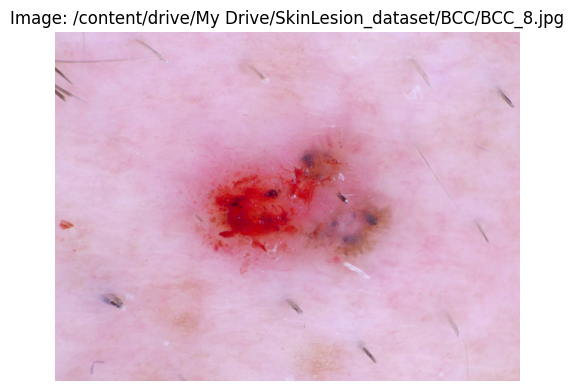

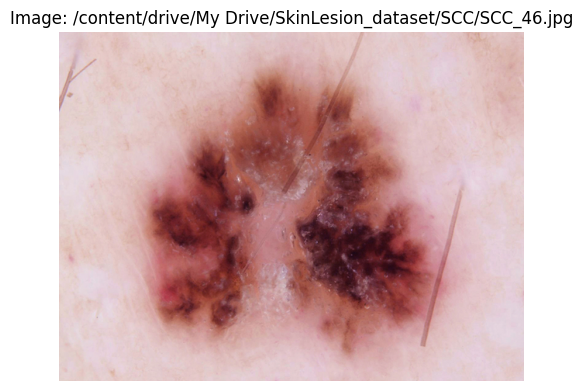

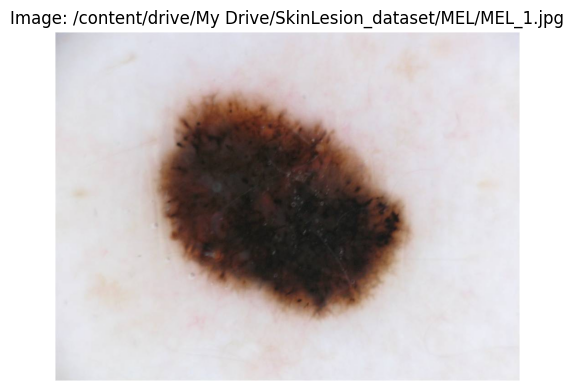

Predicted Classes: ['BCC' 'SCC' 'MEL']


In [ ]:
# SHAP analysis function with pre-extracted features

test_image_paths = [
    '/content/drive/My Drive/SkinLesion_dataset/BCC/BCC_8.jpg',
    '/content/drive/My Drive/SkinLesion_dataset/SCC/SCC_46.jpg',
    '/content/drive/My Drive/SkinLesion_dataset/MEL/MEL_1.jpg'
]
def shap_analysis_with_images(best_estimator, X_train, image_paths, preprocessed_dir):
    # Load preprocessed features from CSV
    selected_features_df_path = os.path.join(preprocessed_dir, 'selected_features.csv')
    selected_features_df = pd.read_csv(selected_features_df_path)

    test_features_list = []
    for img_path in image_paths:
        filename = os.path.basename(img_path).replace('.jpg', '_preprocessed.png')
        feature_row = selected_features_df[selected_features_df['filename'] == filename]

        if not feature_row.empty:
            feature_values = feature_row.drop(columns='filename').values[0]
            test_features_list.append(feature_values)
        else:
            print(f"No features found for image {img_path}")

    test_features_array = np.array(test_features_list)

    print(f"Features Array Shape: {test_features_array.shape}")
    if test_features_array.size == 0:
        raise ValueError("Extracted features array is empty. Check the features CSV file.")
    if test_features_array.shape[1] != X_train.shape[1]:
        raise ValueError(f"Number of features in test images ({test_features_array.shape[1]}) does not match the number of features used during training ({X_train.shape[1]}).")

    # SHAP explanation
    explainer = shap.KernelExplainer(best_estimator.predict, X_train)
    shap_values = explainer.shap_values(test_features_array)

    # Display SHAP force plots
    for i, (img_path, shap_value) in enumerate(zip(image_paths, shap_values)):
        img = plt.imread(img_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f'Image: {img_path}')
        plt.axis('off')
        plt.show()

        shap.force_plot(explainer.expected_value, shap_value, feature_names=[f'feature_{j}' for j in range(test_features_array.shape[1])])
        plt.title(f'SHAP for {img_path}')
        plt.savefig(f'shap_image_{i}.png')
        plt.close()

    return best_estimator.predict(test_features_array)

# Test specific images and analyze with SHAP
predictions = shap_analysis_with_images(best_model, X_train, test_image_paths, preprocessed_dir)
class_names = label_encoder.inverse_transform(predictions)
print("Predicted Classes:", class_names)